In [1]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
from numpy import concatenate

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import Callback
from keras.layers import Activation

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
%matplotlib inline

In [2]:
"""
    Create place for model save
    
    Arguments:
    ----------
    models: str
            Name of directory model will be saved in
"""
if not os.path.isdir(os.path.realpath('models')):
    os.mkdir(os.path.realpath('models'))

In [3]:
df_healthy = pd.read_csv('result_healthy_pandas.csv', engine='python', header=None)
df_healthy.head()

,0,1,2,3
0,0,100,0.014603,0.192922
1,1,100,0.054449,0.164364
2,2,100,0.107646,0.090811
3,3,100,0.133722,0.086496
4,4,100,0.112652,0.099235


#df_healthy.loc[df_healthy[1] == 100]

In [4]:
df_faulty = pd.read_csv("result_faulty_pandas.csv", engine='python', header=None)
df_faulty.head()

,0,1,2,3
0,0,105,-0.083004,-0.402075
1,1,105,-0.195734,-0.004725
2,2,105,0.233419,-0.106631
3,3,105,0.103958,-0.074169
4,4,105,-0.181115,0.208947


In [5]:
"""
    Get actual recording data; drop file_id and index data
    
    Arguments:
    ----------
    df: DataFrame
            DataFrame storing either "result_healthy_pandas.csv" or "result_faulty_pandas.csv"
    file_id: str/int
            Identifier of .mat file data comes from
"""

def get_recording(df,file_id):
    return np.array(df.sort_values(by=0, ascending=True).loc[df[1] == file_id].drop(0,1).drop(1,1))


In [6]:
healthy_sample = get_recording(df_healthy,100)
faulty_sample = get_recording(df_faulty,125)

Text(0.5, 1.0, 'Healthy samples - Total view')

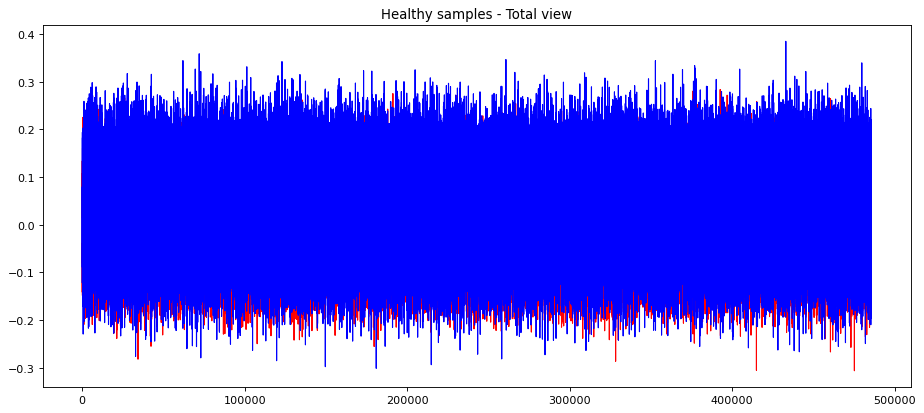

In [7]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_sample)
ax.plot(range(0,size), healthy_sample[:,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), healthy_sample[:,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Healthy samples - Total view")

Text(0.5, 1.0, 'Faulty samples -Total view')

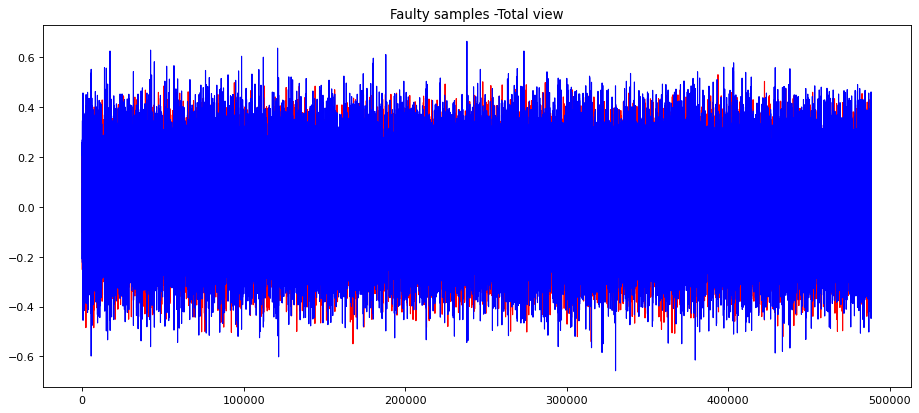

In [8]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_sample)
ax.plot(range(0,size), faulty_sample[:,1], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,size), faulty_sample[:,0], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Faulty samples -Total view")

Text(0.5, 1.0, 'Healthy samples - Closer look')

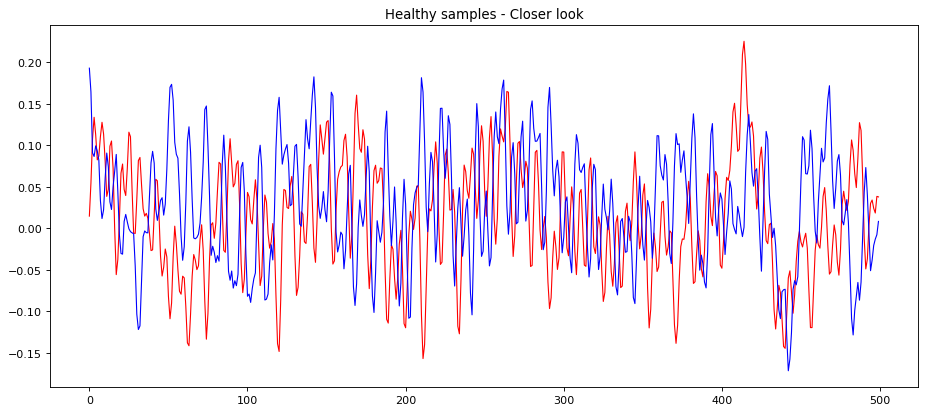

In [9]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), healthy_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), healthy_sample[:500,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Healthy samples - Closer look")

Text(0.5, 1.0, 'Faulty samples - Closer look')

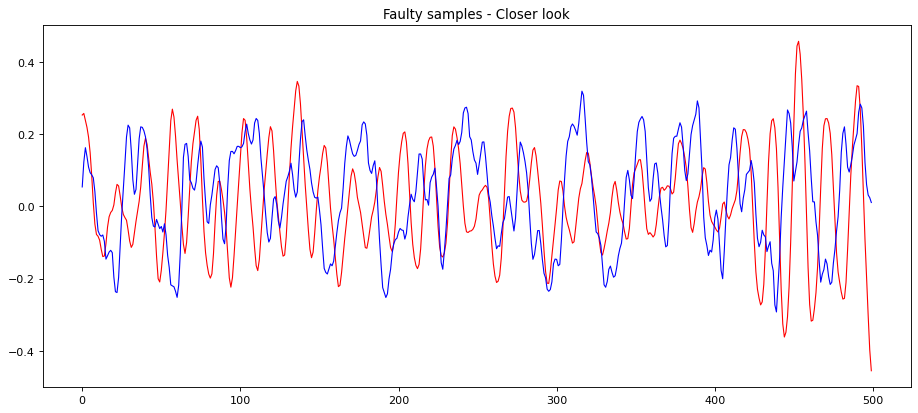

In [10]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(range(0,500), faulty_sample[:500,0], '-', color='red', animated = True, linewidth=1)
ax.plot(range(0,500), faulty_sample[:500,1], '-', color='blue', animated = True, linewidth=1)
ax.set_title("Faulty samples - Closer look")

In [11]:
"""
    Callback function (reqd) for loss history and model checkpoints
    
    Arguments:
    ----------
    Callback: tf.keras.callbacks.Callback()
    self/logs
"""
class LossHist(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [12]:
"""
    ML/NN Network design
    
    Design:
    -------
    Epochs/Timesteps = 100 samples
    Dimensions = 2 recordings
    
    Architecture:
    -------------
    - Sequential
    - LSTM (size => 100/2 = 50)
    - Dense (size = 2)

"""

timesteps = 100
dim = 2
lossHistory = LossHist()

model = Sequential()
model.add(LSTM(50,input_shape=(timesteps,dim),return_sequences=True))
model.add(Dense(2))
model.compile(loss='mae', optimizer='adam')

def train(data):
    history = model.fit(data, data, epochs=20, batch_size=72, validation_data=(data, data), verbose=0, shuffle=False,callbacks=[lossHistory])
    model.save('models/k_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_traces=True,
              )
def score(data):
    yhat =  model.predict(data)
    return yhat

In [13]:
"""
    Enabling TensorFlow backend in compatibility mode
"""

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [14]:
"""
    Trim samples to form proper epochs in scope of timesteps
    
    Arguments:
    ----------
    df: DataFrame
        Intending df for trimming
    file_id: str/int
        Name of .mat file iterating in epoch
"""

def create_trimmed_recording(df,file_id):
    recording = get_recording(df,file_id) 
    samples = len(recording)
    trim = samples % 100
    recording_trimmed = recording[:samples-trim]
    recording_trimmed.shape = (int((samples-trim)/timesteps),timesteps,dim)
    return recording_trimmed


#df_healthy.drop(0,1).drop(2,1).drop(3,1)

In [15]:
pd.unique(df_healthy.iloc[:,1])

array([100,  97,  98], dtype=int64)

In [16]:
"""
    Training on Healthy data and comparing accuracy

"""

with tf.device('/GPU:1'):
    file_ids = pd.unique(df_healthy.iloc[:,1])
    start = time.time()
    for file_id in file_ids:
        recording_trimmed = create_trimmed_recording(df_healthy,file_id)
        print("Starting training on %s" % (file_id))
        train(recording_trimmed)
        print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

    print("Finished job on after %s seconds" % (time.time()-start))
    healthy_losses = lossHistory.losses


Starting training on 100
Epoch 1/20
68/68 [==============================] - 10s 21ms/step - loss: 0.0519 - val_loss: 0.0377
Epoch 2/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0331 - val_loss: 0.0208
Epoch 3/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0159 - val_loss: 0.0067
Epoch 4/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0067 - val_loss: 0.0047
Epoch 5/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 6/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 8/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
68/68 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 10/20
68/68 [==============================] - 1s 11ms/step - loss: 0.0043 - 

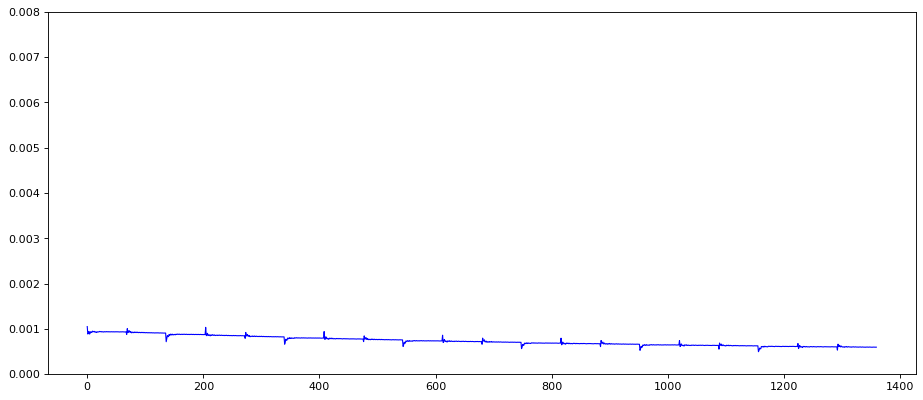

In [17]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(healthy_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), healthy_losses, '-', color='blue', animated = True, linewidth=1)

"""
    Short example of model; for a single file_id
"""

start = time.time()
for file_id in [105]:
    recording_trimmed = create_trimmed_recording(df_faulty,file_id)
    print("Starting training on %s" % (file_id))
    train(recording_trimmed)
    print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

print("Finished job on after %s seconds" % (time.time()-start))
faulty_losses = lossHistory.losses

In [18]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7899106491734756735
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6920390592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7272993940443825452
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [19]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
"""
    Predicting on Faulty data and comparing accuracy - Autoencoder behaviour

"""
with tf.device('/GPU:1'):
    file_ids = pd.unique(df_faulty.iloc[:,1])
    start = time.time()
    for file_id in file_ids:
        recording_trimmed = create_trimmed_recording(df_faulty,file_id)
        print("Starting training on %s" % (file_id))
        train(recording_trimmed)
        print("Finished training on %s after %s seconds" % (file_id,time.time()-start))

    print("Finished job on after %s seconds" % (time.time()-start))
    faulty_losses = lossHistory.losses


Starting training on 105
Epoch 1/20
17/17 [==============================] - 0s 15ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 2/20
17/17 [==============================] - 0s 14ms/step - loss: 0.0041 - val_loss: 0.0037
Epoch 3/20
17/17 [==============================] - 0s 13ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/20
17/17 [==============================] - 0s 13ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 5/20
17/17 [==============================] - 0s 14ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 6/20
17/17 [==============================] - 0s 14ms/step - loss: 0.0025 - val_loss: 0.0024
Epoch 7/20
17/17 [==============================] - 0s 13ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 8/20
17/17 [==============================] - 0s 14ms/step - loss: 0.0022 - val_loss: 0.0022
Epoch 9/20
17/17 [==============================] - 0s 13ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/20
17/17 [==============================] - 0s 14ms/step - loss: 0.0020 - v

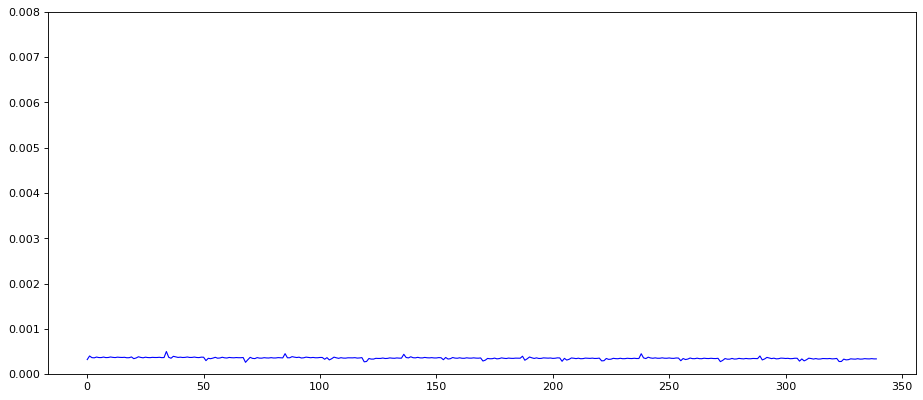

In [21]:
fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
size = len(faulty_losses)
plt.ylim(0,0.008)
ax.plot(range(0,size), faulty_losses, '-', color='blue', animated = True, linewidth=1)

In [23]:
from keras.models import load_model

loaded_model = load_model('models/k_model.h5')

x = tf.random.uniform((10, 3))
assert np.allclose(model.predict(x), loaded_model.predict(x))

ValueError: in user code:

    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\training.py:1478 predict_function  *
        return step_function(self, iterator)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\training.py:1468 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\training.py:1461 run_step  **
        outputs = model.predict_step(data)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\training.py:1434 predict_step
        return self(x, training=False)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\AquAJ3T-EVGA\Anaconda3\envs\dev\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:223 assert_input_compatibility
        str(tuple(shape)))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 3)
